<a href="https://colab.research.google.com/github/dvsseed/PyTorch_CNN_MNIST/blob/master/PyTorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN—PyTorch—MNIST @Date:2020-08-12
##### *以下示範碼執行所需時間約90秒(GPU)、360秒(CPU)*
---



![Coding Style](https://4.bp.blogspot.com/-0pYHjZbv-48/Wkc5cPmrXDI/AAAAAAAAHkM/H2hnkggGlT83-B81ofzNZygpZNlqBcO9ACLcBGAs/s640/paradigm_shift.jpg)

**CNN--PyTorch Coding**
1. 匯入套件
2. 使用GPU(加速)或CPU
3. 圖片轉換(預處理)
4. 準備資料集(MNIST)：Train(42,000)、Validation(18,000)、Test(10,000)
5. 建立CNN模型(2Conv+3FC)
6. 設定CNN參數(Epochs, Learning Rate, Loss function, Optimizer)
7. 訓練CNN模型(計算Accuracy, Loss並顯示結果)
8. 預測CNN模型(計算Accuracy, Loss並顯示結果)
9. 評估CNN模型-驗證指標(Validation index): 混淆矩陣(Confusion Matrix)
10. 調參優化
11. 儲存模型相關數據
12. 讀取模型相關數據
13. 測試CNN模型(計算Accuracy, Loss並顯示各類別的結果)

---




![Packages](https://manalelaidouni.github.io/assets/img/pexels/Pytorch-package-hierarchy.jpg)

---



In [1]:
# -*- coding: utf-8 -*-
# 匯入套件(Import Libraries)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time



---


![PyTorch](https://miro.medium.com/max/864/0*dp6NCTWXmbelZwBd)

In [2]:
print('PyTorch version:', torch.__version__)  # PyTorch version
print('CUDA version:', torch.version.cuda)  # Corresponding CUDA version
print('cuDNN version:', torch.backends.cudnn.version())  # Corresponding cuDNN version

PyTorch version: 1.6.0+cu101
CUDA version: 10.1
cuDNN version: 7603




---


![CUDA](https://upload.wikimedia.org/wikipedia/commons/5/59/CUDA.png)

In [3]:
# How many GPUs are there?
if torch.cuda.is_available(): print('GPUs:', torch.cuda.device_count())

# Which GPU Is The Current GPU?
if torch.cuda.is_available(): print('GPU device:', torch.cuda.current_device())

# Get the name of the current GPU
if torch.cuda.is_available(): print('GPU name:', torch.cuda.get_device_name(torch.cuda.current_device()))

# 確認 GPU 是否可用
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cpu




---


![Image transform](https://www.cse.iitb.ac.in/~vkaushal/talk/auto-augment/featured_huc5f6bfa335655300e966e45366a24701_359424_720x0_resize_lanczos_2.png)

In [4]:
# 圖片的轉換(Transform)
Transform = transforms.Compose(
  [
   transforms.ToTensor(),  # 轉成 Tensor 型態
   transforms.Normalize((0.5,), (0.5,)),  # 正規化
  ]
)



---


![MNIST](https://jason-chen-1992.weebly.com/uploads/1/0/8/5/108557741/example-images-from-the-mnist-dataset_orig.png)

In [5]:
# 資料集(Dataset)
BatchSize = 16

TrainSet0 = datasets.MNIST(root='MNIST', download=True, train=True, transform=Transform)
TestSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=Transform)

# 切分70%當作訓練集、30%當作驗證集
train_size = int(0.7 * len(TrainSet0))
valid_size = len(TrainSet0) - train_size
TrainSet, ValidSet = torch.utils.data.random_split(TrainSet0, [train_size, valid_size])

TrainLoader = dset.DataLoader(TrainSet, batch_size=BatchSize, shuffle=True)  # 打亂數據則將shuffle=True
ValidLoader = dset.DataLoader(ValidSet, batch_size=BatchSize, shuffle=True)
TestLoader = dset.DataLoader(TestSet, batch_size=BatchSize, shuffle=False)
Test10kLoader = dset.DataLoader(TestSet, batch_size=len(TestSet), shuffle=False)



---


![CNN](https://jason-chen-1992.weebly.com/uploads/1/0/8/5/108557741/dnn-for-mnist_1_orig.png)

In [6]:
# 建立CNN模型(Model)的架構
class Net(nn.Module):  # 使用 torch.nn 來建構神經網路
  def __init__(self, NumClasses):
    super(Net, self).__init__()
    # # Convolution 1, input_shape=(1,28,28)
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=1,  # input height
           out_channels=32,  # n_filters
           kernel_size=3,   # filter size
           stride=1,     # filter movement/step
           padding=1     # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
      ),
      nn.BatchNorm2d(num_features=32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # output_shape=(32,14,14)
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # input_shape=(32,14,14)
      nn.BatchNorm2d(num_features=64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # output_shape=(64,7,7)
    )
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    # self.drop_out = nn.Dropout2d(p=0.5)
    # self.fc_drop = nn.Dropout2d(p=0.5)
    self.fc = nn.Sequential(
      nn.Linear(in_features=64*7*7, out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=64),
      nn.ReLU(),
      nn.Linear(in_features=64, out_features=NumClasses)
    )

  def forward(self, x):
    out = self.features(x)
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = out.view(x.size(0), -1)
    # out = self.drop_out(out)
    out = self.fc(out)
    # out = self.fc_drop(out)
    return F.log_softmax(out, dim=1)

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


NumClasses = 10
Cnn = Net(NumClasses).to(device)
print(Cnn)  # 列印結構

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)




---


**Dimension Calculations**

* $O=\frac{W−K+2\times P}{S}+1$
> * O: output height/length
> * W: input height/length
> * K: filter size(kernel size)
> * P: padding, $P=\frac{K−1}{2}$
> * S: stride

![Model](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/images/cnn10-2n.png)

In [7]:
# Counting number parameters in a CNN model
def count_model_layers(model):
  conv = 0
  fc = 0
  for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
      conv += 1
    elif isinstance(layer, nn.Linear):
      fc += 1

  return conv, fc

num_parameters = sum(torch.numel(parameter) for parameter in Cnn.parameters())
print('Model Params: %.2f M' % (num_parameters / 1e6))
print('Model: Convolutional layer: %s + Fully connected layer: %s' % count_model_layers(Cnn))

params = list(Cnn.parameters())
print(len(params))  # 列印層數

for name, parameters in Cnn.named_parameters():
  print(name, ':', parameters.size())

Model Params: 0.43 M
Model: Convolutional layer: 2 + Fully connected layer: 3
14
features.0.weight : torch.Size([32, 1, 3, 3])
features.0.bias : torch.Size([32])
features.1.weight : torch.Size([32])
features.1.bias : torch.Size([32])
features.4.weight : torch.Size([64, 32, 3, 3])
features.4.bias : torch.Size([64])
features.5.weight : torch.Size([64])
features.5.bias : torch.Size([64])
fc.0.weight : torch.Size([128, 3136])
fc.0.bias : torch.Size([128])
fc.2.weight : torch.Size([64, 128])
fc.2.bias : torch.Size([64])
fc.4.weight : torch.Size([10, 64])
fc.4.bias : torch.Size([10])




---


![Comparison of Adam to other deep learning optimizers when training on the MNIST dataset](https://debuggercafe.com/wp-content/uploads/2020/06/adam_result_mnist.png)

In [8]:
# 參數(Parameters)設定
Epochs = 3  # 訓練的迭代次數
LearningRate = 0.001  # Learning rate，反向傳播的學習率
Criterion = nn.CrossEntropyLoss()  # 損失函數(Loss function)
Optimizer = optim.Adam(Cnn.parameters(), lr=LearningRate)  # 優化器optimize all cnn parameters



---


![Training](https://2.bp.blogspot.com/-lo4ANmafiQM/WVpEeo68VPI/AAAAAAAAWxE/7FJBUGp-GrQFL5fUYEg6tQAJWXUHrtgWgCLcBGAs/s1600/3812_1.png)

In [9]:
# 訓練(Train)模型
def training_net(Epochs, trainLoader, Criterion, Optimizer):
  training_loss = []
  validing_loss = []
  training_accuracy = []
  validing_accuracy = []
  for epoch in range(Epochs):
    train_start = time.time()
    train_losss = 0.0
    t_loss = 0.0
    train_correct = 0
    train_total = 0
    Cnn.train()
    for times, tdata in enumerate(TrainLoader):
      tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)

      # 反向傳播(Backward propagation)，通過計算預測結果與正解的距離（即loss function），來反向地更新模型的權重，使模型越來越準確
      # Zero the parameter gradients
      Optimizer.zero_grad()  # 將參數、梯度緩衝區歸零

      # Foward + backward + optimize
      toutputs = Cnn(tinputs)
      _, predicted = torch.max(toutputs.data, 1)
      train_total += tlabels.size(0)
      train_correct += (predicted == tlabels).sum().item()

      train_loss = Criterion(toutputs, tlabels)
      train_loss.backward()
      train_accuracy = 100 * train_correct / float(train_total)
      train_losss += train_loss.item()
      t_loss = train_losss / (float(train_total) / BatchSize)

      Optimizer.step()

    training_accuracy.append(train_accuracy)
    training_loss.append(t_loss)
    # Print statistics
    print('Epoch: [%d/%d, %d/%d] - <Train>, loss: %.6f, accuracy: %.4f %%, duration: %.4f sec' % (
        (epoch + 1),
        Epochs,
        (times + 1),
        len(TrainLoader),
        t_loss,
        train_accuracy,
        (time.time() - train_start))
    )

    valid_start = time.time()
    valid_losss = 0.0
    v_loss = 0.0
    valid_correct = 0
    valid_total = 0
    Cnn.eval()
    for times, vdata in enumerate(ValidLoader):
      vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
      voutputs = Cnn(vinputs)
      _, predicted = torch.max(voutputs.data, 1)
      valid_total += vlabels.size(0)
      valid_correct += (predicted == vlabels).sum().item()
      valid_loss = Criterion(voutputs, vlabels)
      valid_accuracy = 100 * valid_correct / float(valid_total)
      valid_losss += valid_loss.item()
      v_loss = valid_losss / (float(valid_total) / BatchSize)

    validing_accuracy.append(valid_accuracy)
    validing_loss.append(v_loss)
    # Print statistics
    print('Epoch: [%d/%d, %d/%d] - <Validation>, loss: %.6f, accuracy: %.4f %%, duration: %.4f sec' % (
        (epoch + 1),
        Epochs,
        (times + 1),
        len(ValidLoader),
        v_loss,
        valid_accuracy,
        (time.time() - valid_start))
    )

  return training_loss, training_accuracy, validing_loss, validing_accuracy

print('Started Training.')
training_loss, training_accuracy, validing_loss, validing_accuracy = training_net(Epochs, TrainLoader, Criterion, Optimizer)
print('Finished Training.')

Started Training.
Epoch: [1/3, 2625/2625] - <Train>, loss: 0.139243, accuracy: 95.6738 %, duration: 93.0101 sec
Epoch: [1/3, 1125/1125] - <Validation>, loss: 0.069054, accuracy: 97.8944 %, duration: 14.3080 sec
Epoch: [2/3, 2625/2625] - <Train>, loss: 0.057319, accuracy: 98.2214 %, duration: 96.3177 sec
Epoch: [2/3, 1125/1125] - <Validation>, loss: 0.058300, accuracy: 98.3667 %, duration: 14.1035 sec
Epoch: [3/3, 2625/2625] - <Train>, loss: 0.042224, accuracy: 98.6976 %, duration: 93.2061 sec
Epoch: [3/3, 1125/1125] - <Validation>, loss: 0.060259, accuracy: 98.3389 %, duration: 13.9412 sec
Finished Training.


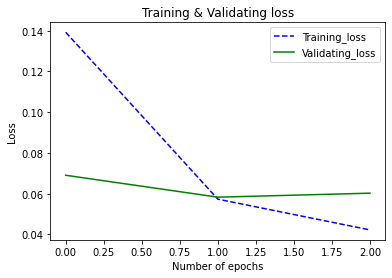

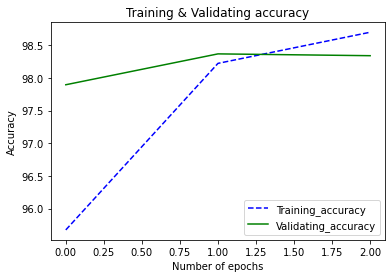

In [10]:
# 訓練、預測結果視覺化(visualization)
plt.plot(range(Epochs), training_loss, 'b--', label='Training_loss')
plt.plot(range(Epochs), validing_loss, 'g-', label='Validating_loss')
plt.title('Training & Validating loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(Epochs), training_accuracy, 'b--', label='Training_accuracy')
plt.plot(range(Epochs), validing_accuracy, 'g-', label='Validating_accuracy')
plt.title('Training & Validating accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



---


![Confusion Matrix](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)
![F1 Score](https://4.bp.blogspot.com/-0CJRaFYOJZE/XMfpAkCCKRI/AAAAAAAAEjk/5q7y2hIULvsz62QApm7DOAXuc2u02Sn5wCEwYBhgL/s400/f%2Bscore.jpg)

In [11]:
# 儲存模型
PATH = './cnn.pth'
torch.save(Cnn, PATH)

In [12]:
# 模型評估-驗證指標(validation index)--混淆矩陣(Confusion Matrix)
def evaluate(ValidLoader):
  confusion_matrix = torch.zeros(NumClasses, NumClasses)
  with torch.no_grad():
    Cnn.eval()
    for inputs, labels in ValidLoader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = Cnn(inputs) 
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(labels.view(-1), predicted.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

  # print('Confusion Matrix:\n{}'.format(confusion_matrix.data.numpy()))
  precision = confusion_matrix.diag() / confusion_matrix.sum(1)
  print('Precision: {}'.format(precision.data.numpy()))
  recall = confusion_matrix.diag() / confusion_matrix.sum(0)
  print('Recall: {}'.format(recall.data.numpy()))
  f1 = 2 * (precision * recall) / (precision + recall)
  print('F1 Score: {}'.format(f1.data.numpy()))
  mean = f1.mean()
  print('Mean: {:.6f}'.format(mean))


print('Started Evaluating.')
evaluate(ValidLoader)
print('Finished Evaluating.')

Started Evaluating.
Precision: [0.99601364 0.9975834  0.99416226 0.987062   0.9650757  0.99453884
 0.98946786 0.97915584 0.94450736 0.98458904]
Recall: [0.9886942  0.9754253  0.9770511  0.9924119  0.98926014 0.97559524
 0.99001664 0.9915567  0.9958209  0.95939934]
F1 Score: [0.9923404  0.9863799  0.9855324  0.98972976 0.9770183  0.984976
 0.98974216 0.9853173  0.96948564 0.971831  ]
Mean: 0.983235
Finished Evaluating.


In [13]:
# 讀取模型
Cnn_trained = torch.load(PATH)



---


![Test](https://research.binus.ac.id/airnd/wp-content/uploads/sites/12/2018/03/ConvNet-1-768x346.png)


In [14]:
# 測試(Test)
def testing_net(TestLoader):
  test_start = time.time()
  test_losss = 0.0
  t_loss = 0.0
  test_correct = 0
  test_total = 0

  Cnn_trained.eval()  # 模型評估模式，沒有要繼續訓練模型、而只拿來應用

  with torch.no_grad():
    for data in TestLoader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = Cnn_trained(inputs)
      _, predicted = torch.max(outputs.data, 1)
      test_loss = Criterion(outputs, labels)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()
      test_accuracy = 100 * test_correct / float(test_total)
      test_losss += test_loss.item()
      t_loss = test_losss / (float(test_total) / BatchSize)

    print('Accuracy of the network on the 10000 test images: %.4f %%, loss: %.4f, duration: %.4f sec' % (
        test_accuracy,
        t_loss,
        (time.time() - test_start)
        )
    )

print('Started Testing.')
testing_net(TestLoader)
print('Finished Testing.')

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

with torch.no_grad():
  Cnn_trained.eval()  # 模型評估模式
  for data in TestLoader:
    inputs, labels = data[0].to(device), data[1].to(device)

    outputs = Cnn_trained(inputs)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      # print(class_correct)
      # print(class_total)

# 列印10個類別的Accuracy
for i in range(len(class_total)):
  print('Accuracy of class[%d]: %3f' % (i, (class_correct[i] / class_total[i])))

Started Testing.
Accuracy of the network on the 10000 test images: 98.5000 %, loss: 0.0484, duration: 7.3264 sec
Finished Testing.
Accuracy of class[0]: 0.990276
Accuracy of class[1]: 0.998590
Accuracy of class[2]: 0.992331
Accuracy of class[3]: 0.992013
Accuracy of class[4]: 0.982732
Accuracy of class[5]: 0.986989
Accuracy of class[6]: 0.984694
Accuracy of class[7]: 0.987055
Accuracy of class[8]: 0.951220
Accuracy of class[9]: 0.983077


In [15]:
# 只測試一張圖片
correct = 0
total = 0
num = 1000  # 第1000張圖片

Cnn_trained.eval()  # 模型評估模式，沒有要繼續訓練模型、而只拿來應用

with torch.no_grad():
  for data in Test10kLoader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[num].view((-1,1,28,28), -1)
    outputs = Cnn_trained(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += 1
    correct += (predicted == labels[num]).sum().item()
    break

print('Accuracy of the network on the #%d test image: %f %% -> [predict: %d, label: %d]' % (
    num,
    (100 * correct / total),
    predicted,
    labels[num]
    )
)

Accuracy of the network on the #1000 test image: 100.000000 % -> [predict: 9, label: 9]


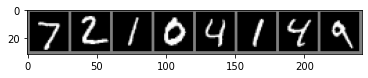

GroundTruth:   7  2  1  0  4  1  4  9


In [16]:
# Test the network on the test data
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# functions to show an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


dataiter = iter(TestLoader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images[:8]))
print('GroundTruth:', ''.join('%3s' % classes[labels[j]] for j in range(8)))